# Classification - Train set size

**Author:** M.G. Baltussen

**Estimated running time:** 20 minutes

**Generated output:**
```
plots_extended/classification_trainsize.png
```


**IMPORTANT**: This notebook will produce warnings in Cell 4 because of very low training set sizes, 
as not every class is represented (e.g. only points classified as 0 are included), which leads to training errors. 
Warnings have not been disabled for transparency, but do not influence the final results.


In [1]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.75, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


In [2]:
""" Load preprocessed data"""

df_all = pd.read_csv("../data/steadystates.csv", index_col=0)

U_chem = df_all[['NaOH', 'Form']].values
X_orig = df_all.drop(columns=['time', 'NaOH', 'Form', 'exp']).values

pad_frac = np.array([-0.05, 0.05])
ranges = np.array([[10, 50], [10, 150]])
pad = pad_frac*np.diff(ranges, axis=1)
extends = ranges + pad
x_extend = extends[0]
y_extend = extends[1]
U = (U_chem - extends[:,0])/(extends[:,1]-extends[:,0])

X = preprocessing.StandardScaler().fit_transform(X_orig)

In [3]:
from collections import OrderedDict

""" Generating training labels from inputs """
y_xor = np.logical_xor(U[:,0] < 0.5, U[:,1] < 0.5)
y_circle = ((U[:,0]-0.5)**2 + (U[:,1]-0.5)**2) < 0.125
y_sin =  U[:,1] > 0.5 + 0.5*np.sin(U[:,0]*np.pi*2/0.8 - np.pi/4)

y_eye = 1*(((U[:,0]-0.5)**2 + (U[:,1]-0.5)**2) < 0.16) - 1*(((U[:,0]-0.5)**2 + (U[:,1]-0.5)**2) < 0.04)
y_dots = 1*(((U[:,0]-0.3)**2 + (U[:,1]-0.3)**2) < 0.05) + 1*(((U[:,0]-0.7)**2 + (U[:,1]-0.7)**2) < 0.05)


def triangle(x, y):
   z_triangle_b1 =  (y < x/3 + 1/3)
   z_triangle_b2 = (x < y/3 + 1/3)
   z_triangle_b3 = (y < -x + 1) 
   z_triangle_1 = -1*np.logical_and(z_triangle_b1, z_triangle_b3)
   z_triangle_2 = 0.0* np.logical_and(z_triangle_b2, ~z_triangle_b1)
   z_triangle_3 = np.logical_and(~z_triangle_b2, ~z_triangle_b3)
   z_triangle = z_triangle_1 + z_triangle_2 + z_triangle_3
   return z_triangle

y_linear = U[:,1] > U[:,0] 
y_and = np.logical_and(U[:,0] > 0.5, U[:,1] > 0.5)
y_or = np.logical_or(U[:,0] > 0.5, U[:,1] > 0.5)
y_triangle = triangle(U[:,0], U[:,1])
y_checker = np.logical_xor((U[:,0] // 0.33333)%2, (U[:,1] // 0.33333)%2)

y_train_linear = OrderedDict(
   Linear= y_linear,
   AND= y_and,
   OR= y_or,
   Triangle = y_triangle,
   Checkers = y_checker,
)

y_train = OrderedDict(
   AND = y_and,
   OR = y_or,
   Linear= y_linear,
   Triangle = y_triangle,
   XOR= y_xor,
   Checkers = y_checker,
   Circle= y_circle,
   Sine= y_sin,
   Concentric = y_eye,
   Dots = y_dots,
)


In [5]:
"""
IMPORTANT: This notebook will produce warnings for very low training set sizes, 
because not every class is represented (e.g. only points classified as 0 are included), 
which leads to training errors. 
Warnings have not been disabled for transparency, but do not influence the final results.
"""

datasize_val_scores = {k: [] for k in y_train.keys()}
datasize_train_scores = {k: [] for k in y_train.keys()}

for i, (k, v) in enumerate(y_train.items()):
    reg = svm.LinearSVC(max_iter=10_000, tol=1e-4, dual=True)
    y = y_train[k]

    for train_fraction in np.arange(0.1, 0.97, 0.01):
    # for size in range(10, X.shape[0]):
    #     idx_select = np.random.choice(X.shape[0], size=size, replace=False)

    #     X_select = X[idx_select]
    #     y_select = y[idx_select]
        X_select = X
        y_select = y

        scores = model_selection.cross_validate(reg, X_select, y_select, 
                                                scoring = metrics.make_scorer(metrics.matthews_corrcoef), 
                                                cv=model_selection.ShuffleSplit(train_size=train_fraction, test_size=5, n_splits=100), 
                                                n_jobs=10, return_train_score=True)

        reg.fit(X_select, y_select)
        y_predict = reg.predict(X_select)
        train_score = reg.score(X_select, y_select)

        datasize_val_scores[k].append(scores)
        datasize_train_scores[k].append(train_score)

datasize_val_scores_mean = {k: np.array([i['test_score'].mean() for i in datasize_val_scores[k]]) for k, i in datasize_val_scores.items()}
datasize_val_scores_std = {k: np.array([i['test_score'].std() for i in datasize_val_scores[k]]) for k, i in datasize_val_scores.items()}


/home/mathieu/anaconda3/envs/formose_rc/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mathieu/anaconda3/envs/formose_rc/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mathieu/anaconda3/envs/formose_rc/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mathieu/anaconda3/envs/formo

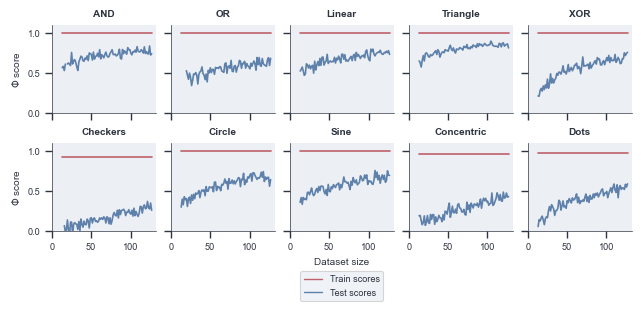

In [6]:
titledict = {'fontweight': 'bold'}

fig, axes = plt.subplots(2, 5, figsize=(6.3, 3.0), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

# dataset_sizes = range(10, X.shape[0])
# dataset_sizes = range(2, 30)
# dataset_sizes = X.shape[0] * (1- 1/np.arange(2,30))
dataset_sizes= X.shape[0] * np.arange(0.1, 0.97, 0.01)

for i, (k, v) in enumerate(y_train.items()):
    axes[i].set_title(k, fontdict=titledict)
    axes[i].plot(dataset_sizes, datasize_val_scores_mean[k], color='C8')
    # axes[i].plot(dataset_sizes, datasize_val_scores_mean[k] + datasize_val_scores_std[k])
    # axes[i].plot(dataset_sizes, datasize_val_scores_mean[k] - datasize_val_scores_std[k])

    axes[i].plot(dataset_sizes, datasize_train_scores[k], color='C0')
    axes[i].set_ylim(0, 1.1)
    axes[i].set_xlim(0, 132)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=1, label='Line'),
                   Line2D([0], [0], color='C8', lw=1, label='Line')]
                   
axes[7].legend(handles=legend_elements, labels=['Train scores', 'Test scores'],
                loc='upper center', bbox_to_anchor=(0.5, -0.4)
)
axes[7].set_xlabel("Dataset size")
axes[0].set_ylabel((r"$\Phi$ score"))
axes[5].set_ylabel((r"$\Phi$ score"))
sns.despine()

save_si("classification_trainsize")

